## Task 3: Reflection and contemplation - $g_{OO} (r)$ determination in water
### Goal: Compute $g_{OO} (r)$ in water, using the provided $\verb|.traj|$ file.

In [1]:
from ase.io import read

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import simpson, quad, romberg
from scipy.optimize import fmin

In [2]:
# Reading all snapshots (trajectory).
trajs = read(f'./tif320-computational-materials-and-molecular-physics/Na-aimd/cluster24.traj', index='2000:') # Reference.
# Note how, now, we include 'index='2000:', such that we only consider thermal equilibrium.
# Getting volume from the first snapshot.
Vol = trajs[0].get_volume()                                    
Cell = trajs[0].get_cell()                          
print(f'Unit cell volume = {Vol} [A^3].')
print(f'Cell dimensions = {Cell} [A].')

# Total number of snapshots read.
snap_n = len(trajs); print(f'Number of snaphots = {snap_n}.')

Unit cell volume = 718.449183 [A^3].
Cell dimensions = Cell([8.956369831609006, 8.956369831609006, 8.956369831609006]) [A].
Number of snaphots = 10000.


In [3]:
# Definitions:
n_bins = 100
r_max  = Cell[0, 0]/2      # Periodic boundary conditions means we can re-center ('the cell') around each individual atom. So, r_max = Cell_x/2.
max_d = []                 # Checking what is the biggest distance that is verified.
global_count = np.zeros(n_bins)

for snapshot in trajs:
    temp_counts = np.zeros(n_bins)
    for i in range(24):
        atoms = snapshot[:24]                                       # Selecting the 24 'O' atoms.
    
        dist = np.delete(atoms.get_all_distances(mic = True)[i], i) # Need np.delete to get rid of the 'self-distance'.
        max_d.append(sorted(dist)[-1])                              # Checking what is the biggest distance that is verified.

        counts, bins  = np.histogram(dist, bins = np.linspace(0, r_max, n_bins + 1, endpoint = True))

        temp_counts += counts
    global_count += temp_counts/(24) # Number of Oxygen atoms! (And, what about 'double counts'?! *2 Try this, maybe...) 

# Averaging over all the snapshots:
global_count /= snap_n
print(f'Maximum verified distance = {sorted(max_d)[-1]}.')

Maximum verified distance = 7.700924751637268.


## Ther's somthing missing!!!!

In [4]:
# Definitions:
final_count = np.zeros(n_bins)
dr          = bins[1] - bins[0]
ind         = list(range(n_bins))

# Number density? We're not really sure how this is defined. Will need to check...
Vol_Max = (4/3)*np.pi*(r_max**3)
rho = sum(global_count)/Vol_Max

print(f'sum(global_count) = {sum(global_count)}.')
print(f'Value of \\rho = {rho}.')               # These two are reasonably close... So, that's probably not the problem.
print(f'Value of \\rho (Unit cell)= {24/Vol}.') # These two are reasonably close... So, that's probably not the problem.

for bin_count, r, i in zip(global_count, bins, ind): # This doesn't seem to work very well. I guess that's not the definition.
    if (bin_count > 0):
        Volume = 4*np.pi*(r**2)*dr
        final_count[i] = bin_count/(Volume*rho)

# For later.
Integrand = np.zeros(len(bins[:-1]))
for i, r_i in enumerate(bins[:-1]):
    Integrand[i] = 4*np.pi*r_i**2 * rho * final_count[i] # Integrand = 4*pi*r^2 * \rho * g

sum(global_count) = 11.778049999999974.
Value of \rho = 0.03130968628271364.
Value of \rho (Unit cell)= 0.033405285395111936.


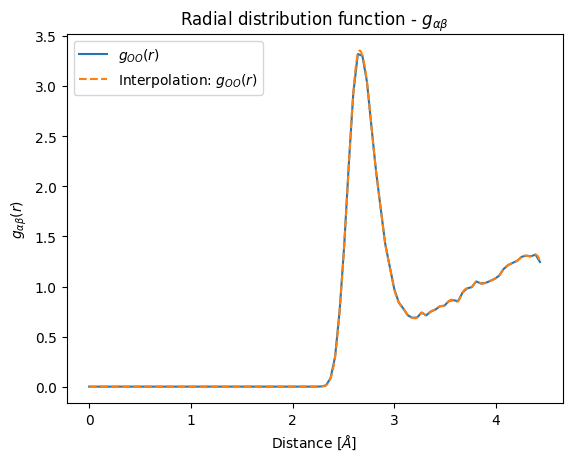

Total integral (Interpolator)= (11.566776547709853, 1.6618731860648853e-07).
Total integral (Discrete bins)= 11.56391527777775.


In [7]:
# CubicSpline/interp1d:
Interpolator = interp1d(bins[:-1], final_count, kind = 'cubic')
xnew = np.linspace(0, bins[-2], 50000, endpoint = True) # Here we have '-2', because we left out the last value of r, above.
ynew = Interpolator(xnew)

# Plotting results as graph:
plt.plot(bins[:-1], final_count, label = r'$g_{OO} (r)$')
plt.plot(xnew, ynew, linestyle = 'dashed', label = r'Interpolation: $g_{OO} (r)$')

# plt.grid(True)
plt.xlabel(r'Distance [$\AA$]')
plt.ylabel(r'$g_{\alpha \beta} (r)$')
plt.title(r'Radial distribution function - $g_{\alpha \beta}$')
plt.legend()
plt.savefig('Task3.png', dpi = 500)
plt.show()

# For integration, using quad (Interpolator).
func = lambda r: 4*np.pi*r**2 * rho * Interpolator(r)
print(f'Total integral (Interpolator)= {quad(func, bins[0], bins[-2], limit = 150)}.') # This is integrating everything!
                                                                                       # Not just until the first minimum, or whatever it was.

# Simpson method, for comparison with the trapezoidal/simpson rule used before.
print(f'Total integral (Discrete bins)= {simpson(Integrand, x = bins[:-1])}.') # This is integrating everything!

In [6]:
a = 0; b = fmin(Interpolator, 3.5)[0]                            # b - Minimum value (r).
print(f'Found minimum: r = {b}.')
print(f'1st solvation shell = {quad(func, a, b, limit = 150)}.') # Integrating until the obtained r value.

Optimization terminated successfully.
         Current function value: 0.682174
         Iterations: 14
         Function evaluations: 28
Found minimum: r = 3.2040039062499996.
1st solvation shell = (4.092424524296129, 5.9286995637475264e-08).
